# **기계학습(8585) - 기말고사 대체 과제**

**<div style="text-align: right"> 202120990 김도환 </div>**

## **제품 review 데이터의 감성 분석**

### **프로젝트 개요:**

학생들은 텍스트 데이터를 감성으로 분류하는 감성 분석 시스템을 개발합니다. 이 프로젝트는 전처리, 모델 선택, 학습, 평가 및 결과 시각화를 포함합니다.

### **프로젝트 목표(보고서 목차):**

1. **감성 분석의 기본 이해**: 감성 분석이 무엇이며 그 응용에 대해 학습
2. **데이터 전처리**: 머신 러닝 작업을 위해 데이터 전처리하는 경험을 쌓음
3. **모델 선택 및 학습**: 수업에서 활용한 모델을 활용해서 구현하고 그 강점과 약점을 이해
4. **평가**: 적절한 지표를 사용하여 모델의 성능을 평가
5. **시각화 및 해석**: 결과를 시각화하고 해석

### **프로젝트 구성 요소:**

1. **데이터:**
    - `wine_review.csv` 파일을 분석합니다.
2. **데이터 전처리:**
    - 데이터 정리(노이즈 제거, 결측값 처리 등)
    - 텍스트 토큰화 및 불용어 제거
    - 텍스트 정규화(스테밍 또는 표제어 추출)
3. **모델 구현:**
    - 수업에서 활용한 모델을 적용
4. **모델 학습 및 튜닝:**
    - 데이터셋을 학습 및 테스트 세트로 분할.
    - 모델 학습 및 하이퍼파라미터 튜닝 (예: 그리드 서치 또는 랜덤 서치 사용)
    - 교차 검증과 같은 기술을 사용하여 견고성 보장.
5. **모델 평가:**
    - 정확도, 정밀도, 재현률, F1 점수 및 ROC-AUC와 같은 지표를 사용하여 모델 평가.
    - 오버피팅과 언더피팅을 논의하고 이를 해결하는 방법 학습.
6. **시각화 및 보고:**
    - Matplotlib 또는 Seaborn과 같은 라이브러리를 사용하여 결과 시각화
    - 혼동 행렬 및 ROC 곡선 생성
    - 보고서에 결과 요약.
    
<br/>

과제를 시작하기 전, 과제에 필요한 모듈을 다운로드 합니다.

In [1]:
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [2]:
# 경고를 무시합니다.
import warnings
warnings.filterwarnings("ignore")

# 한글 폰트를 설정해줍니다. (폰트 깨짐 방지)
import numpy
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
font_path = "./fonts/NanumGothic.ttf"
fm.fontManager.addfont(font_path)
plt.rcParams["font.family"] = "NanumGothic"

## **1) 데이터 로드하기**

---


In [3]:
import pandas as pd

df = pd.read_csv("./wine_review.csv")
print(f"전체 리뷰 개수: {len(df)}\n")
print("===============   DataFrame info   ===============")
print(df.info())

전체 리뷰 개수: 2890

===============   DataFrame info   ===============
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2890 entries, 0 to 2889
Data columns (total 32 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    2890 non-null   object 
 1   asins                 870 non-null    object 
 2   brand                 2825 non-null   object 
 3   categories            2890 non-null   object 
 4   dateAdded             2890 non-null   object 
 5   dateUpdated           2890 non-null   object 
 6   descriptions          2738 non-null   object 
 7   dimension             1838 non-null   object 
 8   ean                   2166 non-null   object 
 9   flavors               151 non-null    object 
 10  keys                  2890 non-null   object 
 11  manufacturer          849 non-null    object 
 12  manufacturerNumber    2457 non-null   object 
 13  name                  2890 non-null   object 
 14  revie

총 2,890개의 샘플이 존재합니다. 이제 감성분석을 위해 사용할 칼럼을 선정합니다.

`reviews.rating`, `reviews.text`, `reviews.title` 이 세 개의 칼럼을 주요 특성으로 사용하였습니다.

In [4]:
df = df[["reviews.rating", "reviews.text", "reviews.title"]]
df.head(10)

,reviews.rating,reviews.text,reviews.title
0,5.0,This a fantastic white wine for any occasion!,My Favorite White Wine
1,5.0,"Tart, not sweet...very refreshing and delicious!",Yum!!
2,5.0,I was given this wine so it was a delightful s...,A New Favorite!
3,5.0,This is a phenomenal wine and my new favorite ...,"Bold, Flavorful, Aromatic, Delicious"
4,5.0,4 750ml bottles for the price of two With way ...,"Yum! Plus, Environmentally Friendly!"
5,5.0,I LOVE Becks NA. It tastes just like a regular...,Great Taste
6,3.0,This wine has a wonderful but strong aroma its...,Simply Wonderful
7,2.0,I would give one more star if it came clean on...,A Sweet Red.
8,5.0,Delicious and very affordable,NaN
9,5.0,This is a very smooth red with Aromas of cocoa...,Charles & Charles Red Blend


## **2) 데이터 중복값 및 결측치 제거**

---

각 열에 대해서 중복을 제외한 샘플의 수를 카운트합니다.

In [5]:
df["reviews.rating"].nunique(), df["reviews.text"].nunique(), df["reviews.title"].nunique()

(5, 2550, 2158)

`reviews.text`를 확인해보면 중복을 제외한 경우 2,550개의 데이터가 존재한 것을 확인할 수 있습니다.
현재 2,890개의 데이터가 존재하므로 이는 현재 갖고 있는 데이터에 중복인 샘플이 있다는 의미입니다.
중복된 샘플을 제거해줍니다.

In [6]:
df.drop_duplicates(subset=["reviews.text"], inplace=True)
print(f"전체 리뷰 개수: {len(df)}\n")

전체 리뷰 개수: 2551



다음으로, NULL 값 유무를 확인합니다.

In [7]:
print(f"제목 결측치 개수: {df['reviews.title'].isnull().sum()}")
print(f"리뷰 결측치 개수: {df['reviews.text'].isnull().sum()}")

제목 결측치 개수: 41
리뷰 결측치 개수: 1


제목과 리뷰 내용 데이터에 결측치가 존재함을 확인하였습니다. 리뷰 내용이 NULL인 행은 제거해주고, 제목 내용이 NULL인 행은 공백으로 채워줍니다.

In [8]:
df = df.dropna(subset=["reviews.text"])
df["reviews.title"] = df["reviews.title"].fillna("")
df.head(10)

,reviews.rating,reviews.text,reviews.title
0,5.0,This a fantastic white wine for any occasion!,My Favorite White Wine
1,5.0,"Tart, not sweet...very refreshing and delicious!",Yum!!
2,5.0,I was given this wine so it was a delightful s...,A New Favorite!
3,5.0,This is a phenomenal wine and my new favorite ...,"Bold, Flavorful, Aromatic, Delicious"
4,5.0,4 750ml bottles for the price of two With way ...,"Yum! Plus, Environmentally Friendly!"
5,5.0,I LOVE Becks NA. It tastes just like a regular...,Great Taste
6,3.0,This wine has a wonderful but strong aroma its...,Simply Wonderful
7,2.0,I would give one more star if it came clean on...,A Sweet Red.
8,5.0,Delicious and very affordable,
9,5.0,This is a very smooth red with Aromas of cocoa...,Charles & Charles Red Blend


현재 데이터셋에 rating 분포도를 확인합니다. rating이 골고루 분포되어 있을수록 모델 학습에 용이한 데이터셋이라고 볼 수 있습니다.

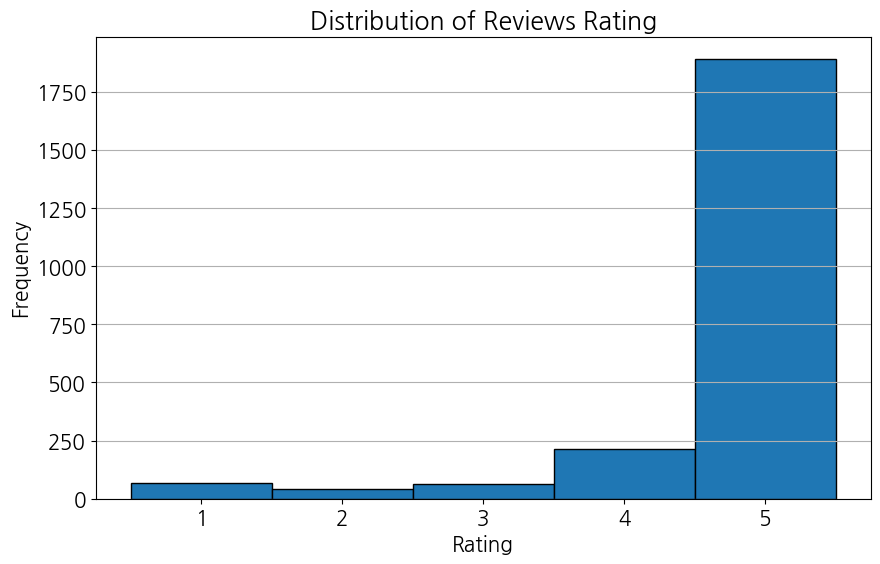

In [9]:
import matplotlib.pyplot as plt

# 데이터 분포도 시각화
plt.figure(figsize=(10, 6))
plt.hist(df['reviews.rating'], bins=range(1, 7), edgecolor='black', align='left')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Distribution of Reviews Rating')
plt.xticks(range(1, 6))  # Rating이 1에서 5까지인 경우
plt.grid(axis='y')

# 그래프 보여주기
plt.show()

위 그래프를 확인해보면 4~5점에 데이터가 밀집해있는 것을 알 수 있습니다.
이는 데이터가 긍정적인 리뷰가 대다수이고 부정적인 리뷰는 매우 적다는 것을 의미하며, 부정적인 리뷰를 제대로 분류하지 못할 수 있습니다.

## **3) 텍스트 데이터 전처리**

---

텍스트 데이터를 전처리합니다. 전처리 과정은 크게 네 가지로 진행됩니다.

1. 노이즈 제거
    - 텍스트를 모두 소문자로 바꿔주고, 숫자 제거 및 추가 공백 제거, 특수 문자 제거를 합니다.
2. 토큰화
    - 텍스트를 작은 단위로 토큰화 합니다.
3. 불용어 제거
    - 의미 없는 단어(예: 'the', 'and' 등)를 제거하여 중요한 정보만 남깁니다.
4. 표제어 추출
    - 단어의 기본 형태를 찾아 변형된 단어를 통일합니다. (예: 'better' -> 'good')


In [10]:
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
import nltk

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# 전처리 함수 정의
def preprocess_text(text):
    # 노이즈 제거
    text = text.lower()                  # 소문자 변환
    text = re.sub(r'\d+', '', text)      # 숫자 제거
    text = re.sub(r'\s+', ' ', text)     # 추가 공백 제거
    text = re.sub(r'[^\w\s]', '', text)  # 특수 문자 제거
    # 토큰화
    tokens = word_tokenize(text)
    # 불용어 제거
    tokens = [word for word in tokens if word not in stopwords.words("english")]
    # 표제어 추출
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]  
    return ' '.join(tokens)

# 텍스트 전처리
df["reviews.text"] = df["reviews.text"].apply(preprocess_text)
df["reviews.title"] = df["reviews.title"].apply(preprocess_text)

df.head(10)

[nltk_data] Downloading package punkt to
[nltk_data]     /home/students/cs/202120990/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/students/cs/202120990/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/students/cs/202120990/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,reviews.rating,reviews.text,reviews.title
0,5.0,fantastic white wine occasion,favorite white wine
1,5.0,tart sweetvery refreshing delicious,yum
2,5.0,given wine delightful surprise find flavorful ...,new favorite
3,5.0,phenomenal wine new favorite red,bold flavorful aromatic delicious
4,5.0,ml bottle price two way le packaging yes pleas...,yum plus environmentally friendly
5,5.0,love beck na taste like regular ale smell like...,great taste
6,3.0,wine wonderful strong aroma bit bitter bite st...,simply wonderful
7,2.0,would give one star came clean bottle called s...,sweet red
8,5.0,delicious affordable,
9,5.0,smooth red aroma cocoa coffee tobacco sweet bl...,charles charles red blend


## **4) 모델 구현**

---

수업 시간에 사용한 VADER 감정 추론 모델을 사용하여 해당 텍스트의 감정이 긍정적인지 부정적인지를 판단합니다.

NLTK의 VADER를 통해 리뷰 제목과 리뷰 내용을 감성 분석하여 `text_vader_compound`와 `title_vader_compound`에 저장합니다.

`text_vader_compound`와 `title_vader_compound`의 평균을 내서 `vader_compound`에 저장해 해당 리뷰의 최종 vader score를 계산합니다.

In [11]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# NLTK 패키지 다운로드
nltk.download("vader_lexicon")

# VADER 초기화
vader_sentiment = SentimentIntensityAnalyzer()

# VADER를 사용하여 감성 점수 계산
df["text_vader_scores"] = df["reviews.text"].apply(lambda review: vader_sentiment.polarity_scores(review))
df["title_vader_scores"] = df["reviews.title"].apply(lambda review: vader_sentiment.polarity_scores(review))

# compound 점수만 추출하여 별도의 컬럼에 저장
df["text_vader_compound"] = df["text_vader_scores"].apply(lambda score_dict: score_dict["compound"])
df["title_vader_compound"] = df["title_vader_scores"].apply(lambda score_dict: score_dict["compound"])
df["vader_compound"] = (df["text_vader_compound"] + df["title_vader_compound"])/2

df[["reviews.rating", "reviews.text", "reviews.title", "text_vader_compound", "title_vader_compound", "vader_compound"]].head(10)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/students/cs/202120990/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


,reviews.rating,reviews.text,reviews.title,text_vader_compound,title_vader_compound,vader_compound
0,5.0,fantastic white wine occasion,favorite white wine,0.5574,0.4588,0.50810
1,5.0,tart sweetvery refreshing delicious,yum,0.5719,0.0000,0.28595
2,5.0,given wine delightful surprise find flavorful ...,new favorite,0.9118,0.4588,0.68530
3,5.0,phenomenal wine new favorite red,bold flavorful aromatic delicious,0.4588,0.7430,0.60090
4,5.0,ml bottle price two way le packaging yes pleas...,yum plus environmentally friendly,0.6669,0.4939,0.58040
5,5.0,love beck na taste like regular ale smell like...,great taste,0.9771,0.6249,0.80100
6,3.0,wine wonderful strong aroma bit bitter bite st...,simply wonderful,0.7269,0.5719,0.64940
7,2.0,would give one star came clean bottle called s...,sweet red,0.6908,0.4588,0.57480
8,5.0,delicious affordable,,0.5719,0.0000,0.28595
9,5.0,smooth red aroma cocoa coffee tobacco sweet bl...,charles charles red blend,0.8122,0.0000,0.40610


`vader_compound`의 값이 0.05 이상인지 아닌지를 기준으로, 이상이면 1(긍정), 아니라면 0(부정)으로 분류해 라벨을 붙여줍니다.

In [12]:
# VADER의 compound 점수를 기준으로 감성 라벨 생성
def vader_sentiment_label(score):
    if score >= 0.05:
        return 1
    else:
        return 0

df["label"] = df["vader_compound"].apply(vader_sentiment_label)

df[["reviews.rating", "reviews.text", "reviews.title", "vader_compound", "label"]].head(10)

,reviews.rating,reviews.text,reviews.title,vader_compound,label
0,5.0,fantastic white wine occasion,favorite white wine,0.50810,1
1,5.0,tart sweetvery refreshing delicious,yum,0.28595,1
2,5.0,given wine delightful surprise find flavorful ...,new favorite,0.68530,1
3,5.0,phenomenal wine new favorite red,bold flavorful aromatic delicious,0.60090,1
4,5.0,ml bottle price two way le packaging yes pleas...,yum plus environmentally friendly,0.58040,1
5,5.0,love beck na taste like regular ale smell like...,great taste,0.80100,1
6,3.0,wine wonderful strong aroma bit bitter bite st...,simply wonderful,0.64940,1
7,2.0,would give one star came clean bottle called s...,sweet red,0.57480,1
8,5.0,delicious affordable,,0.28595,1
9,5.0,smooth red aroma cocoa coffee tobacco sweet bl...,charles charles red blend,0.40610,1


7번 행을 보면 rating이 2.0인데 감성 분석 결과는 긍정으로 나온 것을 볼 수 있습니다. 위와 같이 별점과 VADER 감성 추론 모델의 결과가 다르게 나올 수 있습니다. 

두 결과가 다른 데이터가 몇 개 있는지 확인해봅니다.

In [13]:
# 라벨과 별점이 서로 매칭되는지 확인
def is_match(df):
    if (df["label"] and df["reviews.rating"] >= 3) or (not df["label"] and df["reviews.rating"] < 3):
        return True
    else:
        return False

df["match"] = df.apply(is_match, axis=1)

print("** 별점이 3점 이상이면 긍정적인 리뷰라고 가정\n")
print(f"별점과 감성 분석 결과가 동일함: {df[df['match'] == True].shape[0]}") 
print(f"별점과 감성 분석 결과가 다름  : {df[df['match'] == False].shape[0]}")

** 별점이 3점 이상이면 긍정적인 리뷰라고 가정

별점과 감성 분석 결과가 동일함: 1995
별점과 감성 분석 결과가 다름  : 555


결과가 동일한 데이터는 총 1995개로, 약 80%의 정확성을 띄는 것을 알 수 있습니다. 어느정도 감정 분석 결과가 별점과 잘 맞다고 볼 수 있습니다.

감성 추론 모델이 분류한 긍정 리뷰와 부정 리뷰의 별점 분포를 그래프를 통해 확인해보겠습니다.

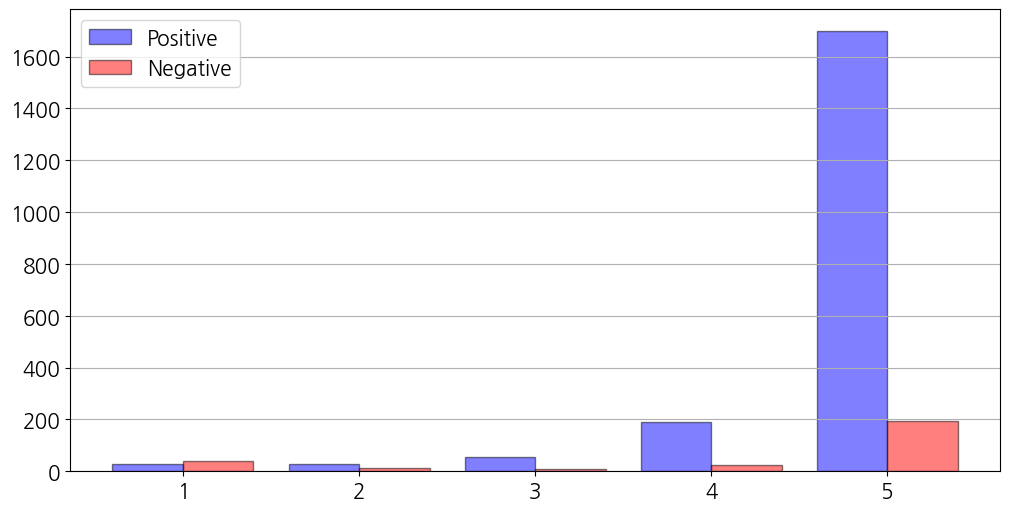

In [14]:
# 긍정, 부정 라벨 데이터 분리
positive_ratings = df[df['label'] == 1]['reviews.rating']
negative_ratings = df[df['label'] == 0]['reviews.rating']

# 히스토그램 설정
plt.figure(figsize=(12, 6))

plt.hist([positive_ratings, negative_ratings], bins=range(1, 7), label=["Positive", "Negative"], color=['blue', 'red'],alpha=0.5, edgecolor='black', align='left')
plt.legend(loc="upper left")
plt.grid(axis='y')

plt.show()

긍정 리뷰와 부정 리뷰의 별점 분포를 보면 다음과 같습니다. 별점 3 ~ 5점만 놓고 보았을 때는 대다수의 데이터를 올바르게 처리하였다고 해석할 수 있지만, 별점 1 ~ 2점 리뷰에 대해서는 그렇지 못하다고 볼 수 있습니다.

이제, 위 데이터를 사용하여 로지스틱 회귀 분석을 진행합니다.

## **5) 데이터셋 분할**

---

데이터셋을 분할하기에 앞서, 먼저 학습에 사용될 데이터셋을 벡터화합니다.

`reviews.title`과 `reviews.text` 칼럼을 하나의 칼럼으로 합친 다음, TF-IDF 벡터화를 진행합니다.

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

y = df["label"]

# 제목과 리뷰 내용 텍스트를 하나로 합쳐줍니다.
df["text"] = df["reviews.title"] + " " + df["reviews.text"]

# TF-IDF
vectorizer = TfidfVectorizer(max_features=1000)
X = vectorizer.fit_transform(df["text"])

이제, 로지스틱 회귀 모델 학습 및 평가에 사용될 데이터셋을 분할합니다.

학습 데이터셋과 평가 데이터셋은 8:2 비율로 분할합니다.

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

## **6) 모델 학습 및 튜닝**

---

모델은 로지스틱 회귀 모델을 사용합니다.

하이퍼파라미터 튜닝 기법으로는 그리드 서치를 사용합니다. `C`와 `max_iter`에 대한 하이퍼파라미터 튜닝을 진행합니다.
교차 검증을 위한 fold 횟수는 5회로 지정하였습니다.

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

model = LogisticRegression()

param_grid = {
    "C": [0.001, 0.01, 0.1, 1, 10, 100],
    "max_iter": [100, 1000]
}

grid_search = GridSearchCV(model, param_grid, cv=5, scoring="accuracy")
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Test accuracy:", grid_search.score(X_test, y_test))

Best parameters: {'C': 10, 'max_iter': 100}
Test accuracy: 0.8862745098039215


`C`의 값이 10일 때, `max_iter` 값이 100일 때가 최적의 하이퍼파라미터 값임을 알 수 있습니다.

이제 그리드 서치를 통해 알아낸 최적의 하이퍼파라미터 값으로 모델 학습을 진행합니다.

In [18]:
# 최적의 모델을 사용 데이터 학습 진행
model = grid_search.best_estimator_
model.fit(X_train, y_train)
yt_pred = model.predict(X_train)
y_pred = model.predict(X_test)

## **7) 모델 평가**

---

최적의 하이퍼파라미터 값으로 학습한 모델에 대해 평가를 진행합니다.

평가 지표로는 정확도(accuracy), 정밀도(precision), 재현률(recall), F1 점수 및 ROC-AUC를 사용합니다.

In [19]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
from sklearn.metrics import confusion_matrix, classification_report,ConfusionMatrixDisplay

# 정확도 평가
print(f"정확도  | Train: {accuracy_score(y_train, yt_pred):.6f}  Test: {accuracy_score(y_test, y_pred):.6f}")

# 정밀도 평가
print(f"정밀도  | Train: {precision_score(y_train, yt_pred, average='weighted'):.6f}  Test: {precision_score(y_test, y_pred, average='weighted'):.6f}")

# 재현율 평가
print(f"재현율  | Train: {recall_score(y_train, yt_pred, average='weighted'):.6f}  Test: {recall_score(y_test, y_pred, average='weighted'):.6f}")

# F1 점수 평가
print(f"F1-score| Train: {f1_score(y_train, yt_pred, average='weighted'):.6f}  Test: {f1_score(y_test, y_pred, average='weighted'):.6f}")

# ROC-AUC 점수 계산
print(f"ROC-AUC | Train: {roc_auc_score(y_train, yt_pred):.6f}  Test: {roc_auc_score(y_test, y_pred):.6f}")

# Classification report
print(f"\n{'='*18} Classification Report (Train) {'='*18}")
print(classification_report(y_train, yt_pred))

print(f"\n{'='*18} Classification Report ( Test) {'='*18}")
print(classification_report(y_test, y_pred))

정확도  | Train: 0.977941  Test: 0.886275
정밀도  | Train: 0.978218  Test: 0.871527
재현율  | Train: 0.977941  Test: 0.886275
F1-score| Train: 0.977072  Test: 0.866453
ROC-AUC | Train: 0.912748  Test: 0.644679

================== Classification Report (Train) ==================
              precision    recall  f1-score   support

           0       0.99      0.83      0.90       248
           1       0.98      1.00      0.99      1792

    accuracy                           0.98      2040
   macro avg       0.98      0.91      0.94      2040
weighted avg       0.98      0.98      0.98      2040


================== Classification Report ( Test) ==================
              precision    recall  f1-score   support

           0       0.71      0.31      0.43        71
           1       0.90      0.98      0.94       439

    accuracy                           0.89       510
   macro avg       0.80      0.64      0.68       510
weighted avg       0.87      0.89      0.87       510



모델 평가 결과는 위와 같습니다. 테스트 데이터에 대한 지표를 해석합니다.

1. 정확도(Accuracy): 0.886275
    - 전체 예측 중에서 올바르게 예측한 비율입니다.
2. 정밀도(Precision): 0.871527
    - 양성으로 예측한 것 중 실제 양성인 비율입니다.
3. 재현율(Recall): 0.886275
    - 실제 양성 중에서 양성으로 예측한 비율입니다.
4. F1-score: 0.866453
    - 정밀도와 재현율의 조화 평균입니다.
5. ROC-AUC: 0.644679
    - ROC 곡선 아래 면적으로, 클래스 구분의 성능을 평가합니다. 1에 가까울수록 완벽한 구분을 의미합니다.
    

학습 데이터와 테스트 데이터를 비교하여 보았을 때, 학습 데이터에서는 모든 지표에서 매우 높은 값을 보이고 있습니다. 
반면, 테스트 데이터에서는 성능이 상대적으로 낮아졌음을 알 수 있습니다. 특히, ROC-AUC 값은 상당히 큰 차이를 보이고 있습니다(Train: 0.91, Test: 0.64).

Classification Report를 보면, 학습 데이터와 다르게 테스트 데이터에서 부정 리뷰(클래스 0)에 대한 모델 성능이 특히 낮다는 것을 알 수 있습니다. 이는 모델이 학습 데이터에 오버피팅 되었을 가능성이 큽니다. 학습 데이터에서의 평가 지표는 모두 좋게 나왔기 때문에 언더피팅의 문제는 아니라고 볼 수 있습니다.

오버피팅의 경우 부정 리뷰(클래스 0)에 대한 데이터 비율이 적어서, 즉 데이터 불균형 문제로 인해 성능이 낮게 나왔음을 추측할 수 있습니다. 이는 부정 리뷰에 대한 데이터 비율을 늘리는 방식을 통해 해결해 볼 수 있습니다.

## **8) 결과 시각화**

---

혼동 행렬과 ROC 곡선에 대해 시각화를 진행합니다.

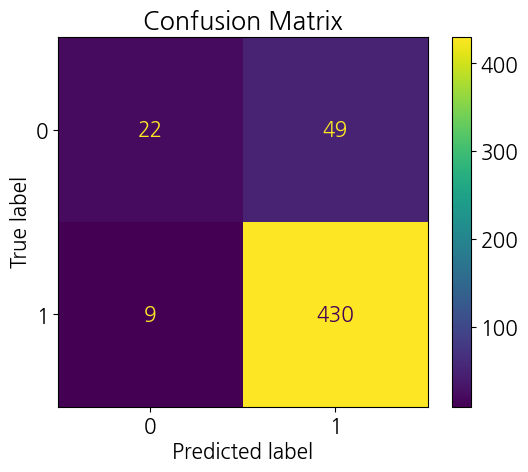

In [20]:
cm = confusion_matrix(y_test, y_pred, labels=[0,1])
display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
display.plot()
plt.title("Confusion Matrix")
plt.show()

혼동 행렬을 확인해보면 긍정 리뷰(클래스 1)에 대해서는 430:9로 분류가 잘 된 것을 확인할 수 있고, 부정 리뷰(클래스 0)에 대해서는 22:49로 아쉬운 성능을 보여주고 있습니다.

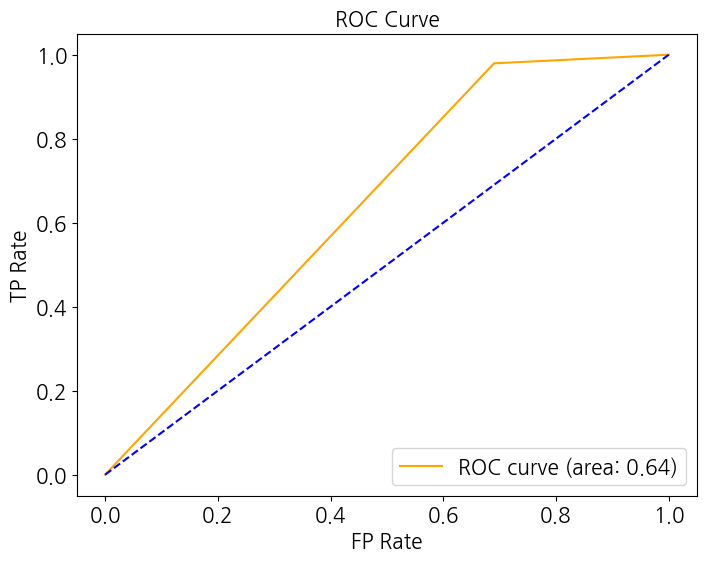

In [21]:
# ROC 곡선 계산
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
# ROC 곡선 아래 면적 계산
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="orange", label=f"ROC curve (area: {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="blue", linestyle="--") 
plt.xlabel("FP Rate")
plt.ylabel("TP Rate")
plt.title('ROC Curve', fontsize=15)
plt.legend(loc='lower right')
plt.show()

곡선 아래 면적(AUC) 값은 0.5에서 1 사이의 값을 가집니다. AUC 값이 0.5에 가까울수록 모델의 분류 성능이 낮고, 1에 가까울수록 분류 성능이 높습니다. 

위 모델의 경우 AUC 값이 0.64로 모델의 성능이 낮음을 확인할 수 있습니다. 반면 학습 데이터의 AUC 값은 0.91로 높았던 것을 생각해보면 오버피팅 문제가 발생하였을 가능성이 높음을 암시합니다.

AUC 값을 높이기 위해서는 오버피팅 문제를 해결할 필요성이 있습니다.

## **9) 마무리**

---

와인 리뷰 데이터를 활용하여 감성 분석을 진행하였습니다. 이 과정에서 노이즈 제거, 불용어 제거와 같은 텍스트 전처리 작업을 진행하였고, NLTK의 VADER 감성 추론 모델을 활용하여 리뷰의 감성 분석을 진행하였습니다.
로지스틱 회귀 모델을 사용하여 모델 학습을 진행하였고, 그리드 서치 알고리즘을 사용하여 모델의 하이퍼파라미터를 조정하였습니다.

학습된 모델을 평가해보았을 때, 학습 데이터의 평가 지표와 테스트 데이터의 평가 지표가 꽤 차이가 나는 것을 확인할 수 있었고, 특히 부정 리뷰에 대한 감성 분류가 테스트 데이터에서 잘 이루어지지 못한 것을 확인할 수 있었습니다.

이는 모델 학습에 사용한 데이터셋이 부정 리뷰에 대한 데이터가 부족했던 원인(데이터 불균형)이 크다고 생각됩니다.

이 문제는 더 많은 리뷰 데이터를 골고루 수집하여 모델의 성능을 강화해 볼 수 있고, 부정 리뷰의 데이터 비율을 늘리거나 긍정 리뷰의 비율을 줄이는 방법으로 해결해 볼 수 있다고 생각합니다.

또한 모델의 경우에도 로지스틱 회귀 모델이 아닌 소프트 벡터 머신(SVM)이나 랜덤 포레스트와 같은 다양한 분류 모델을 사용하여 감성 분석 모델의 성능을 높여볼 수 있을 것으로 보입니다.